# Building a Recommender System from Scratch

### Step 1: Import Dependencies

We are using [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) to represent our data. We will visualize our data with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

Let's download a small version of the MovieLens dataset. See here for zip file url, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our repository:

- ratings.csv
- movies.csv

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [5]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [6]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Step 3: Exploratory Data Analysis

In [7]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


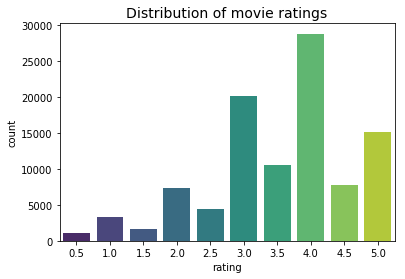

In [8]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [9]:
print(f"Global mean rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Global mean rating: 3.54.
Mean rating per user: 3.66.


#### Best vs. Worst Movie

Which movie has the lowest and highest average rating?

In [10]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]


movieId                      title  genres
1062     1311  Santa with Muscles (1996)  Comedy

`Santa with Muscles` has the lowest average rating.

In [11]:
highest_rated = mean_ratings['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

movieId            title           genres
50       53  Lamerica (1994)  Adventure|Drama

Lamerica may be the "highest" rated movie, but it only has one rating. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [12]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [13]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [14]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

movieId  count      mean  bayesian_avg                             title
284      318    311  4.487138      4.446203  Shawshank Redemption, The (1994)
695      858    200  4.487500      4.425014             Godfather, The (1972)
48        50    201  4.370647      4.314534        Usual Suspects, The (1995)
977     1221    135  4.385185      4.302614    Godfather: Part II, The (1974)
472      527    244  4.303279      4.259541           Schindler's List (1993)

Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [15]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

movieId  count      mean  bayesian_avg                           title
2869     3593     19  1.210526      1.975099        Battlefield Earth (2000)
1242     1556     23  1.652174      2.183723  Speed 2: Cruise Control (1997)
2161     2701     47  2.031915      2.271446           Wild Wild West (1999)
489       546     17  1.735294      2.347912        Super Mario Bros. (1993)
1243     1562     47  2.148936      2.366224           Batman & Robin (1997)

With Bayesian average, it looks like `Battlefield Earth`, `Speed 2: Cruise Control` and `Wild Wild West` are the worst rated movies. `Santa with Muscles` isn't so bad after all.

#### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [16]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]

**How many movie genres are there?**

In [17]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1117,
         'Animation': 447,
         'Children': 583,
         'Comedy': 3315,
         'Fantasy': 654,
         'Romance': 1545,
         'Drama': 4365,
         'Action': 1545,
         'Crime': 1100,
         'Thriller': 1729,
         'Horror': 877,
         'Mystery': 543,
         'Sci-Fi': 792,
         'Documentary': 495,
         'IMAX': 153,
         'War': 367,
         'Musical': 394,
         'Western': 168,
         'Film-Noir': 133,
         '(no genres listed)': 18})

In [18]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4365), ('Comedy', 3315), ('Thriller', 1729), ('Romance', 1545), ('Action', 1545)]


### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="imgs/user-movie-matrix.png" width=60%/>

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [19]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

#### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix is equivalent to the number of ratings in our dataset.

In [20]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.64%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [21]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2391 movies.
Least active user rated 20 movies.


In [22]:
n_ratings_per_movie = X.getnnz(axis=0)

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 341 ratings.
Least rated movie has 1 ratings.


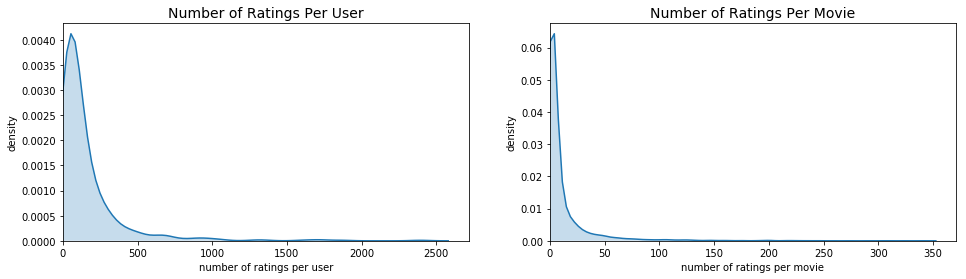

In [23]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

#### Normalizing our data

User-item bias is defined as: $b_{ui} = \mu + b_{u} + b_{i}$

We will perform mean normalization by subtracting $b_{i}$ from each movie's rating.

In [36]:
sum_ratings_per_movie = X.sum(axis=0)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie

Now that we have the mean rating for each movie, we are going to subtract this from our utility matrix. In order to do this, we need to expand our 1D `mean_rating_per_movie` array into a matrix with the same shape as our utility matrix `(n_users, n_movies)`. Numpy's `tile` method is useful for this task.

In [49]:
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1))

In [67]:
X_mean_movie.shape

(671, 9066)

`X_mean_movie` is a matrix of shape (n_users, n_movies) in which each column is populated with a given movie's mean rating.

We can easily normalize our X matrix by subtracting `X_mean_movie` from original `X`.

In [111]:
X_norm = X - csr_matrix(X_mean_movie)

As expected, `X_norm`'s values are different from `X`s. Cells that are empty in the original matrix are now replaced with negative values representing the mean rating of a given movie. 

In [119]:
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

Original X: [[0. 0. 0. ... 0. 0. 0.]]
Normalized X: [[-3.87246964 -3.40186916 -3.16101695 ... -5.         -3.
  -5.        ]]


### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [139]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X.T[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X.T)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [121]:
similar_movies = find_similar_movies(2, X_norm, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[317, 158, 89, 455, 8965, 5108, 7324, 8, 1661]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [122]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 2

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Santa Clause, The (1994)
Casper (1995)
Nick of Time (1995)
Free Willy (1993)
Polar Express, The (2004)
John Q (2002)
Hidalgo (2004)
Tom and Huck (1995)
Switchback (1997)


The results above show the 10 most similar movies to Jumanji. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [123]:
movie_id = 2

similar_movies = find_similar_movies(movie_id, X_norm, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Santa Clause, The (1994)
Casper (1995)
Free Willy (1993)
Polar Express, The (2004)
Milk Money (1994)
Herbie Goes Bananas (1980)
Surviving the Game (1994)
Cosi (1996)
Graveyard Shift (Stephen King's Graveyard Shift) (1990)


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [85]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9125 unique movies in our movies dataset.


In [86]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [87]:
movie_genres.head()

Drama  Western  Mystery  IMAX  Thriller  Fantasy  Animation  Crime  Comedy  \
0      0        0        0     0         0        1          1      0       1   
1      0        0        0     0         0        1          0      0       0   
2      0        0        0     0         0        0          0      0       1   
3      1        0        0     0         0        0          0      0       1   
4      0        0        0     0         0        0          0      0       1   

   Adventure  Film-Noir  (no genres listed)  War  Romance  Children  Action  \
0          1          0                   0    0        0         1       0   
1          1          0                   0    0        0         1       0   
2          0          0                   0    0        1         0       0   
3          0          0                   0    0        1         0       0   
4          0          0                   0    0        0         0       0   

   Musical  Horror  Sci-Fi  Documentary  
0        0       0       0            0  
1        0       0       0            0  
2        0       0       0            0  
3        0       0       0            0  
4        0       0       0            0

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9125, 9125)


The dimensions of our cosine similarity matrix are $M \times M$ where $M$ represents the total number of movies.

In [89]:
def movie_finder(title):
    return movies[movies['title'].str.contains(title)]['title'].tolist()

movie_finder('Toy Story')

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 'Toy Story of Terror (2013)']

In [90]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
title = movie_finder('Toy Story')[0]
n_recommendations = 10

idx = movie_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies['title'].iloc[similar_movies]

Recommendations for Toy Story (1995):


1815                                          Antz (1998)
2506                                   Toy Story 2 (1999)
3003       Adventures of Rocky and Bullwinkle, The (2000)
3217                     Emperor's New Groove, The (2000)
3805                                Monsters, Inc. (2001)
6705                               Shrek the Third (2007)
7146                       Tale of Despereaux, The (2008)
7945    Asterix and the Vikings (Ast√©rix et les Viking...
8366                                         Turbo (2013)
8676                                Boxtrolls, The (2014)
Name: title, dtype: object

With this approach, we are assuming that two movies are "similar" if they have similar genres. These "similar movie" recommendations are based solely on the metadata from our movies dataset. Feel free to test out different movies.

### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

In [124]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [165]:
Z = svd.fit_transform(X)

In [179]:
new_X = svd.inverse_transform(Z)

Let's look at userId 100's recommendations. In the table below, we can see which movies that rated highly:

In [224]:
userId = 100
user_preferences = ratings[(ratings['userId']==userId)&(ratings['rating']>=4)]
user_preferences = user_preferences.merge(movies[['movieId', 'title']])
user_preferences.sort_values('rating', ascending=False)

userId  movieId  rating  timestamp  \
3     100       32     5.0  854193977   
7     100     1073     5.0  854194056   
0     100        1     4.0  854193977   
1     100        3     4.0  854194024   
2     100       25     4.0  854193977   
4     100      608     4.0  854194024   
5     100      745     4.0  854194208   
6     100      802     4.0  854194111   
8     100     1356     4.0  854194086   

                                        title  
3   Twelve Monkeys (a.k.a. 12 Monkeys) (1995)  
7  Willy Wonka & the Chocolate Factory (1971)  
0                            Toy Story (1995)  
1                     Grumpier Old Men (1995)  
2                    Leaving Las Vegas (1995)  
4                                Fargo (1996)  
5      Wallace & Gromit: A Close Shave (1995)  
6                           Phenomenon (1996)  
8             Star Trek: First Contact (1996)

In [225]:
top_N = 5

movie_titles = dict(zip(movies['movieId'], movies['title']))

top_N_indices = new_X[user_mapper[userId]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for UserId {userId}:")
for i in top_N_indices:
    movie_id = movie_inv_mapper[i]
    print(movie_titles[movie_id])

Top 5 Recommendations for UserId 100:
Forrest Gump (1994)
Fugitive, The (1993)
Jurassic Park (1993)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
